# MobileNet Grading of Diabetic Retinopathy in PyTorch

In [5]:
import torch
torch.cuda.is_available()

False

In [6]:
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

ModuleNotFoundError: No module named 'matplotlib'

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['Train', 'Val', 'Test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['Test'], batch_size=32,
                                        shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(image_datasets['Test'], batch_size=32,
                                        shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')

Using device cpu


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



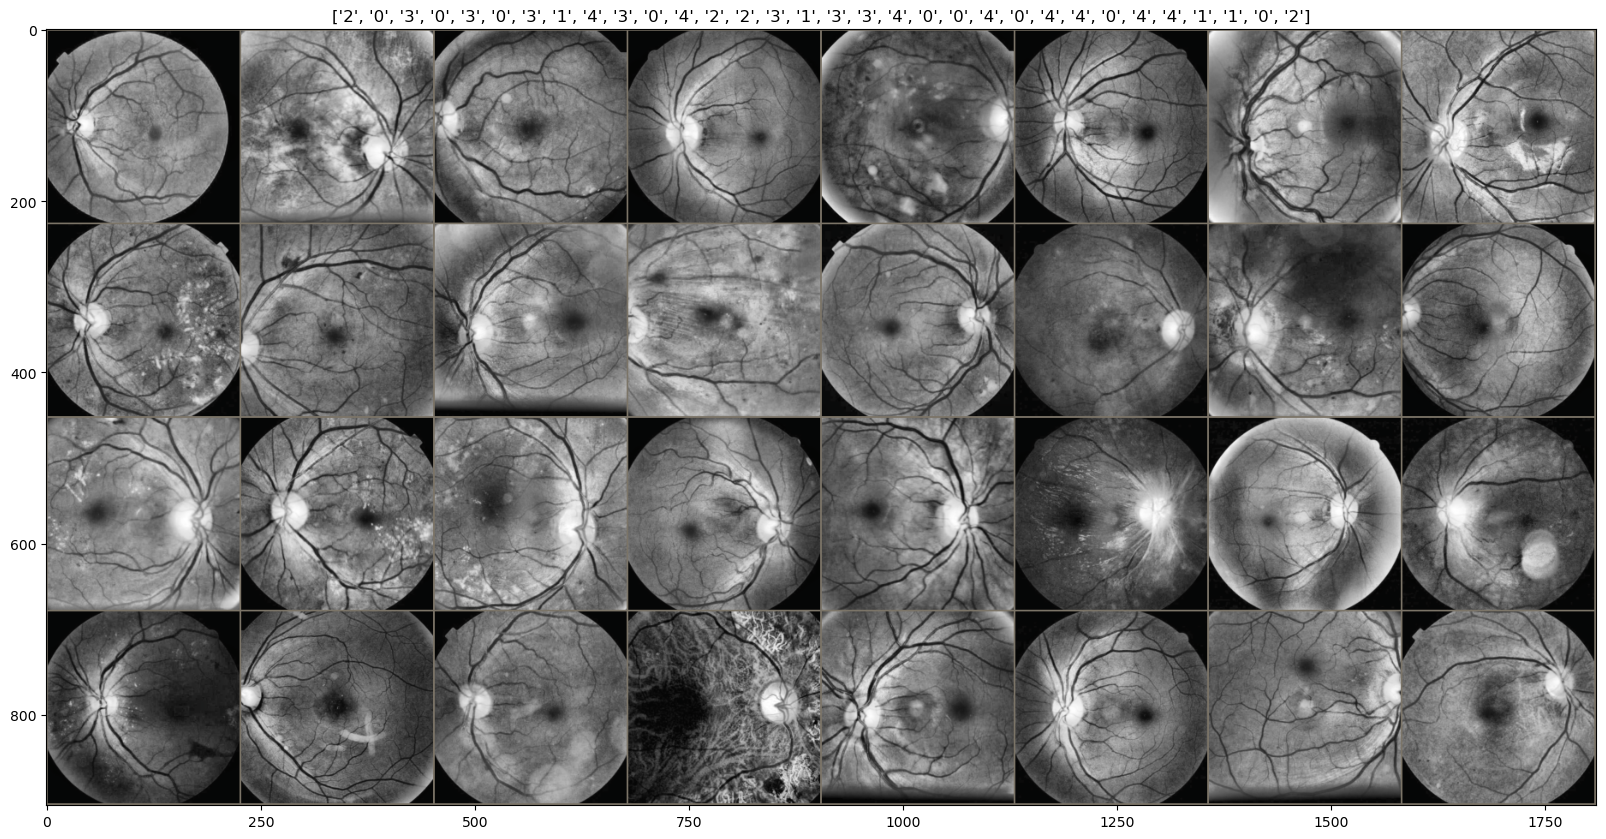

In [ ]:
def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, starting_loss = float('inf')):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = starting_loss
    best_acc = 0.0 

    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs+1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Val']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Update best validation loss and model weights
                if phase == 'Val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best model found with validation loss: {best_loss:.4f}')

            print()

    except KeyboardInterrupt:
        pass

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_loss:.4f} | Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return (best_loss, model)

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [ ]:
import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')
model_weights = models.MobileNet_V3_Large_Weights.DEFAULT

model_ft = models.mobilenet_v3_large(weights=model_weights)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.RMSprop(
    model_ft.parameters(), 
    lr=0.001, 
    weight_decay=1e-5, 
    momentum=0.9
)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.001)

RuntimeError: No CUDA GPUs are available

### Train and evaluate




In [ ]:
warmup_epochs = 20
training_epochs = warmup_epochs * 3
FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')

print(f"Training on device {device}")
for param in model_ft.features.parameters():
    param.requires_grad = False


best_warmup_loss, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs=warmup_epochs
)

for param in model_ft.features.parameters():
    param.requires_grad = True

_, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs=training_epochs,
    starting_point = best_warmup_loss
)

MobileNet_V3_Large_Weights.IMAGENET1K_V2_20_60_Grading_22_Apr_23_14_40
Training on device cpu
Epoch 1/21
----------
Training complete in 0m 15s
Best validation loss: inf | Best validation accuracy: 0.0000


TypeError: train_model() got an unexpected keyword argument 'starting_point'

Visualization

In [ ]:
if not os.path.exists('models'):
  os.mkdir('models')

MODEL_PATH = os.path.sep.join(['models', f'{FILENAME}.pt'])
torch.save(model_ft.state_dict(), MODEL_PATH)

In [ ]:
visualize_model(model_ft)

In [ ]:
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

device = torch.device("cpu")
model_ft = model_ft.to(device)
model_ft.eval()

for inputs, labels in test_dataloader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")

In [ ]:
print("[INFO] Building Matrix")
# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)